In [51]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten
from keras.models import Model, Sequential
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

es = EarlyStopping(monitor='val_acc', mode='max', min_delta=.005, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('best_deep_conv.h5', monitor='val_acc', mode='max', verbose=0, save_best_only=True)

In [13]:
X_train = np.load("data\X_train_valid.npy")
y_train = np.load("data\y_train_valid.npy")

X_test = np.load("data\X_test.npy")
y_test = np.load("data\y_test.npy")

person_train = np.ravel(np.load("data\person_train_valid.npy"))
person_test = np.ravel(np.load("data\person_test.npy"))

In [32]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [14]:
def get_train_val_split(data, targets, person_data, val_size=0.2):
    
    sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
    sss.get_n_splits(data, targets)

    X = data
    y = targets
    p = person_data

    for train_index, val_index in sss.split(data, targets):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        person_train, person_val = p[train_index], p[val_index]
        
    return X_train, y_train, X_val, y_val, person_train, person_val

# X_train, y_train, X_val, y_val, person_train, person_val = get_train_val_split(X_train, y_train, person_train)
# print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, person_train.shape, person_val.shape)

def clean_data(X, y):
    # REMOVE EOG DATA
    X = X[:,:-3,:]
    # RESET Y VALUES and ONE HOT ENCODE
    y = y % 769.0
    print('Data cleaned... X shape = {}, y shape = {}'.format(X.shape, y.shape))
    return X, y

# X_train, y_train = clean_data(X_train, y_train)

def get_train_val_test_for_subject(X_train,
                                   y_train,
                                   X_val, 
                                   y_val,
                                   X_test, 
                                   y_test,
                                   person_train, 
                                   person_val, 
                                   person_test, 
                                   subject=0):
    
    X_train = np.squeeze(X_train[np.argwhere(person_train == subject)])
    y_train = np.squeeze(y_train[np.argwhere(person_train == subject)])
    X_val = np.squeeze(X_val[np.argwhere(person_val == subject)])
    y_val = np.squeeze(y_val[np.argwhere(person_val == subject)])
    X_test = np.squeeze(X_test[np.argwhere(person_test == subject)])
    y_test = np.squeeze(y_test[np.argwhere(person_test == subject)])
    
    print('Data for subject {}'.format(subject))
    print('X_train shape', X_train.shape)
    print('y_train shape', y_train.shape)
    print('X_val shape', X_val.shape)
    print('y_val shape', y_val.shape)
    print('X_test shape', X_test.shape)
    print('y_test shape', y_test.shape)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# X_train_0, y_train_0, X_val_0, y_val_0, X_test_0, y_test_0 = get_train_val_test_for_subject(X_train, y_train,
#                                                                                             X_val, y_val,
#                                                                                             X_test, y_test,
#                                                                                             person_train, 
#                                                                                             person_val, 
#                                                                                             person_test,
#                                                                                             subject=0)

In [15]:
X_train, y_train, X_val, y_val, person_train, person_val = get_train_val_split(X_train, y_train, person_train)

X_train, y_train = clean_data(X_train, y_train)
X_val, y_val = clean_data(X_val, y_val)
X_test, y_test = clean_data(X_test, y_test)

# Targting one specific subject
X_train_0, y_train_0, X_val_0, y_val_0, X_test_0, y_test_0 = get_train_val_test_for_subject(X_train, y_train,
                                                                                            X_val, y_val,
                                                                                            X_test, y_test,
                                                                                            person_train, 
                                                                                            person_val, 
                                                                                            person_test,
                                                                                            subject=0)

# X_train = scale_then_smooth(X_train)
# X_val = scale_then_smooth(X_val)
# X_test = scale_then_smooth(X_test)

Data cleaned... X shape = (1692, 22, 1000), y shape = (1692,)
Data cleaned... X shape = (423, 22, 1000), y shape = (423,)
Data cleaned... X shape = (443, 22, 1000), y shape = (443,)
Data for subject 0
X_train shape (190, 22, 1000)
y_train shape (190,)
X_val shape (47, 22, 1000)
y_val shape (47,)
X_test shape (50, 22, 1000)
y_test shape (50,)


(None, 330, 1, 25)
(None, 107, 1, 50)
(None, 32, 1, 100)
(None, 7, 1, 200)
(None, 4)
Train on 1692 samples, validate on 423 samples
Epoch 1/50
1692/1692 [==============================] - 58s 34ms/step - loss: 2.5331 - acc: 0.2748 - val_loss: 1.5334 - val_acc: 0.3002
Epoch 2/50
1692/1692 [==============================] - 53s 31ms/step - loss: 2.1844 - acc: 0.3008 - val_loss: 1.5120 - val_acc: 0.3239
Epoch 3/50
1692/1692 [==============================] - 52s 31ms/step - loss: 1.9674 - acc: 0.3251 - val_loss: 1.3759 - val_acc: 0.4019
Epoch 4/50
1692/1692 [==============================] - 53s 31ms/step - loss: 1.8079 - acc: 0.3322 - val_loss: 1.4214 - val_acc: 0.3262
Epoch 5/50
1692/1692 [==============================] - 53s 31ms/step - loss: 1.6176 - acc: 0.3629 - val_loss: 1.4193 - val_acc: 0.3073
Epoch 6/50
1692/1692 [==============================] - 52s 31ms/step - loss: 1.5906 - acc: 0.3806 - val_loss: 1.2853 - val_acc: 0.4161
Epoch 7/50
1692/1692 [==============================

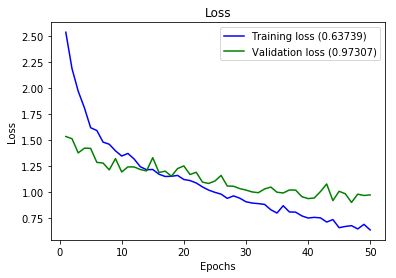

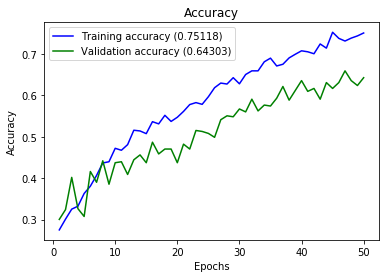

In [49]:
# train_x, train_y = X_train_0, y_train_0
# val_x, val_y = X_val_0, y_val_0
# test_x, test_y = X_test_0, y_test_0 

train_x, train_y = X_train, y_train
val_x, val_y = X_val, y_val
test_x, test_y = X_test, y_test

trials, electrodes, timesteps = train_x.shape

model = Sequential()

ki='glorot_normal'

# Conv Pool Block 1
model.add(Conv2D(filters=25, kernel_size=(10,1), input_shape=(1000, 22, 1), kernel_initializer=ki, data_format="channels_last"))
model.add(Conv2D(filters=25, kernel_size=(1,22), kernel_initializer=ki))
model.add(BatchNormalization())
model.add(Activation(activation = 'elu'))
model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
model.add(Dropout(0.5))

# Conv Pool Block 2
model.add(Conv2D(filters = 50, kernel_size = (10,1), activation = 'elu'))
model.add(BatchNormalization())
model.add(Activation(activation = 'elu'))
model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
model.add(Dropout(0.5))

# Conv Pool Block 3
model.add(Conv2D(filters = 100, kernel_size = (10,1), activation = 'elu'))
model.add(BatchNormalization())
model.add(Activation(activation = 'elu'))
model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
model.add(Dropout(0.5))

# Conv Pool Block 4
model.add(Conv2D(filters = 200, kernel_size = (10,1), activation = 'elu'))
model.add(BatchNormalization())
model.add(Activation(activation = 'elu'))
model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
model.add(Dropout(0.5))

# Classification Layer
model.add(Flatten())
model.add(Dense(units=4, activation = 'softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

train_x = train_x.transpose((0,2,1))[:, :, :, None]
val_x = val_x.transpose((0,2,1))[:, :, :, None]
test_x = test_x.transpose((0,2,1))[:, :, :, None]

history = model.fit(train_x, train_y, epochs=50, batch_size=32, validation_data = (val_x, val_y), callbacks=[es])
score = model.evaluate(test_x, test_y, batch_size=32)
print(score)

plot_history(history)

In [52]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 991, 22, 25)       275       
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 991, 1, 25)        13775     
_________________________________________________________________
batch_normalization_19 (Batc (None, 991, 1, 25)        100       
_________________________________________________________________
activation_18 (Activation)   (None, 991, 1, 25)        0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 330, 1, 25)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 330, 1, 25)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 321, 1, 50)        12550     
__________